In [1]:
import os
import joblib
import inspect
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, f1_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, PowerTransformer


In [2]:
os.chdir(os.getcwd().replace("/notebooks", ""))

In [3]:
from components.dataset_processor import DatasetProcessor

with open("components/labeller.pkl", "rb") as f:
    labeller = joblib.load(f)

with open("components/carrier_frequencies.pkl", "rb") as f:
    carrier_frequencies = joblib.load(f)

carrier_frequencies

CARRIER_DISPLAY_ID
CAUK001009    203
CAUK000912    195
CAUK000863    188
CAUK000155    149
CAUK001047    147
             ... 
CAUK000370      1
CAUK000251      1
CAUK000018      1
CAUK000125      1
CAUK000266      1
Name: count, Length: 89, dtype: int64

In [4]:
date_cols = [
    "FIRST_COLLECTION_SCHEDULE_EARLIEST",
    "FIRST_COLLECTION_SCHEDULE_LATEST",
    "LAST_DELIVERY_SCHEDULE_EARLIEST",
    "LAST_DELIVERY_SCHEDULE_LATEST",
]

train_data = pd.read_csv("data/training_data.csv")

In [5]:
train_data.head()

,DISTANCE,DELIVERY_HOUR,DELIVERY_WINDOW_DURATION,SHIPMENT_DURATION,DELAYED,CARRIER_ID_CONDENSED,IS_VAN
0,264.114503,2,0.500000,7.500000,0,7,0
1,198.282622,2,0.500000,7.000000,0,48,0
2,181.491379,13,1.000000,5.000000,0,44,1
3,145.475712,20,0.750278,6.000278,0,24,0
4,246.554477,14,4.116667,11.033333,1,49,0


In [7]:
# transform delivery hour to sin and cos
def transform_hour(df, col):
    df[col + "_SIN"] = np.sin(2 * np.pi * df[col] / 24)
    df[col + "_COS"] = np.cos(2 * np.pi * df[col] / 24)
    return df.drop(col, axis=1)


In [8]:
train_data = transform_hour(train_data, "DELIVERY_HOUR")


In [ ]:
# Train test split
random_seed = 99
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop(columns=["DELAYED"]),
    train_data["DELAYED"],
    test_size=0.2,
    random_state=random_seed,
)

def power_transform(df, cols, pt, fit=False):
    if fit:
        df[cols] = pt.fit_transform(df[cols])
        return df, pt
    else:
        df[cols] = pt.transform(df[cols])
        return df


pt = PowerTransformer(method="yeo-johnson")
X_train, pt = power_transform(
    X_train,
    [
        "SHIPMENT_DURATION",
        "DELIVERY_WINDOW_DURATION",
        "DISTANCE",
        "KM/HR"
    ],
    pt,
    fit=True,
)
X_test = power_transform(
    X_test,
    [
        "SHIPMENT_DURATION",
        "DELIVERY_WINDOW_DURATION",
        "DISTANCE",
        "KM/HR"
    ],
    pt
)


In [10]:
column_order = X_train.columns.to_list()
column_order

['DISTANCE',
 'DELIVERY_WINDOW_DURATION',
 'CARRIER_ID_CONDENSED',
 'IS_VAN',
 'KM/HR',
 'DELIVERY_HOUR_SIN',
 'DELIVERY_HOUR_COS']

In [11]:
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [12]:
X_train.shape

(2076, 7)

In [13]:
cv = KFold(n_splits=10, random_state=random_seed, shuffle=True)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weight_dict = {0: 1, 1: 4}

models = [
    RandomForestClassifier,
    GradientBoostingClassifier,
    LogisticRegression,
    KNeighborsClassifier,
    LinearDiscriminantAnalysis,
]
model_names = [
    "RandomForestClassifier",
    "GradientBoostingClassifier",
    "LogisticRegression",
    "KNeighborsClassifier",
    "LinearDiscriminantAnalysis"
]

# Create a dataframe of model test scores and metrics
results = []
for model, model_name in zip(models, model_names):

    if model in [RandomForestClassifier, LogisticRegression]:
        if 'random_state' in inspect.signature(model).parameters:
            clf = model(random_state=random_seed, class_weight=class_weight_dict)
        else:
            clf = model(class_weight=class_weight_dict)
    elif model == GradientBoostingClassifier:

        if 'random_state' in inspect.signature(model).parameters:
            clf = model(random_state=random_seed)
        else:
            clf = model()
    elif model in [KNeighborsClassifier, LinearDiscriminantAnalysis]:

        if 'random_state' in inspect.signature(model).parameters:
            clf = model(random_state=random_seed)
        else:
            clf = model()

    # Cross-validation scoring
    acc_score = cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc")

    if model == GradientBoostingClassifier:
        sample_weights = [class_weight_dict[y] for y in y_train]
        clf.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        clf.fit(X_train, y_train)

    # Predictions
    y_proba = clf.predict_proba(X_test)
    y_pred = np.where(y_proba[:, 1] > 0.5, 1, 0)

    # Append results
    results.append(
        {
            "Model": model_name,
            "Cross Val Accuracy": acc_score.mean(),
            "Cross Val Std Dev": acc_score.std(),
            "Test Accuracy": accuracy_score(y_test, y_pred),
            "Test AUC": roc_auc_score(y_test, y_proba[:, 1]),
            "Test Log Loss": log_loss(y_test, y_proba),
            "Test F1": f1_score(y_test, y_pred),
            "Test ROC Curve": roc_curve(y_test, y_proba[:, 1]),
        }
    )


In [15]:
results_df = pd.DataFrame(results)
results_df

,Model,Cross Val Accuracy,Cross Val Std Dev,Test Accuracy,Test AUC,Test Log Loss,Test F1,Test ROC Curve
0,RandomForestClassifier,0.741834,0.039278,0.741811,0.753098,0.659411,0.476562,"([0.0, 0.0, 0.0, 0.00267379679144385, 0.002673..."
1,GradientBoostingClassifier,0.755168,0.046509,0.766859,0.775420,0.484198,0.403941,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005347593582..."
2,LogisticRegression,0.657692,0.051980,0.720617,0.690208,0.551329,0.013605,"([0.0, 0.0, 0.01871657754010695, 0.01871657754..."
3,KNeighborsClassifier,0.702655,0.043984,0.737958,0.763046,1.256559,0.442623,"([0.0, 0.0053475935828877, 0.0374331550802139,..."
4,LinearDiscriminantAnalysis,0.682653,0.044605,0.720617,0.691868,0.548204,0.052288,"([0.0, 0.0, 0.00267379679144385, 0.00267379679..."


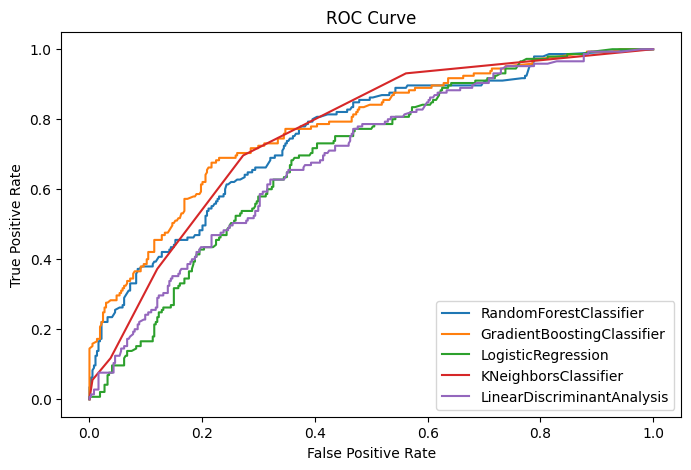

In [16]:
# Plotting ROC curves
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for i, row in results_df.iterrows():
    fpr, tpr, _ = row["Test ROC Curve"]
    plt.plot(fpr, tpr, label=row["Model"])
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
plt.show()

In [17]:
# Create hyperparameter search spaces for RF, GB and KNN

params_dict = {
    "RandomForestClassifier": {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [5, 10, 15, 20, 25, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    },
    "GradientBoostingClassifier": {
            "n_estimators": [100, 200, 300, 400, 500],
            "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
            "subsample": [0.5, 0.7, 1.0],
            "max_depth": [3, 7, 9],
    },
    "KNeighborsClassifier": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
    },
}

In [24]:
# Define class weights
class_weight_dict = {0: 1, 1: 4}

# Grid search for RF, GB, and KNN
results = []

for model, model_name in zip(models, model_names):
    if model_name not in params_dict:
        continue
    if model in [RandomForestClassifier, LogisticRegression]:
        if 'random_state' in inspect.signature(model).parameters:
            clf = model(random_state=random_seed, class_weight=class_weight_dict)
        else:
            clf = model(class_weight=class_weight_dict)
    elif model == GradientBoostingClassifier:
        # GradientBoostingClassifier does not support `class_weight`.
        if 'random_state' in inspect.signature(model).parameters:
            clf = model(random_state=random_seed)
        else:
            clf = model()
    else:
        # For KNeighborsClassifier and other models without class weight, no changes.
        if 'random_state' in inspect.signature(model).parameters:
            clf = model(random_state=random_seed)
        else:
            clf = model()

    # Get parameters for grid search
    params = params_dict[model_name]
    
    # Grid search
    if model == GradientBoostingClassifier:
        # Use sample weights for handling class imbalance
        grid = GridSearchCV(clf, params, cv=cv, scoring="roc_auc", n_jobs=-1)
        sample_weights = [class_weight_dict[y] for y in y_train]
        grid.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        # For other models, `class_weight` is handled in the model instantiation
        grid = GridSearchCV(clf, params, cv=cv, scoring="roc_auc", n_jobs=-1)
        grid.fit(X_train, y_train)
    
    # Predictions
    y_proba = grid.predict_proba(X_test)
    y_pred = np.where(y_proba[:, 1] > 0.5, 1, 0)
    
    # Append results
    results.append(
        {
            "Model": model_name,
            "Best Params": grid.best_params_,
            "Best Score": grid.best_score_,
            "Test Accuracy": accuracy_score(y_test, y_pred),
            "Test AUC": roc_auc_score(y_test, y_proba[:, 1]),
            "Test Log Loss": log_loss(y_test, y_proba),
            "Test F1": f1_score(y_test, y_pred),
            "Test ROC Curve": roc_curve(y_test, y_proba[:, 1]),
        }
    )


/home/neil/.local/share/virtualenvs/digihaul-NCF5dZzl/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [25]:
results_df_tuned = pd.DataFrame(results)
results_df_tuned

,Model,Best Params,Best Score,Test Accuracy,Test AUC,Test Log Loss,Test F1,Test ROC Curve
0,RandomForestClassifier,"{'bootstrap': True, 'max_depth': 10, 'min_samp...",0.766932,0.705202,0.783939,0.575684,0.576177,"([0.0, 0.0, 0.0, 0.00267379679144385, 0.002673..."
1,GradientBoostingClassifier,"{'learning_rate': 0.01, 'max_depth': 7, 'n_est...",0.761914,0.695568,0.765646,0.596195,0.572973,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002673796791..."
2,KNeighborsClassifier,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.713220,0.736031,0.762373,0.873232,0.445344,"([0.0, 0.0, 0.013368983957219251, 0.0508021390..."


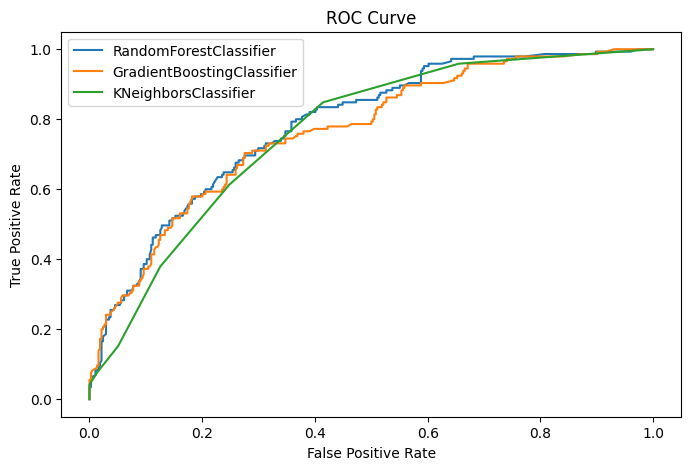

In [26]:
# Plotting ROC curves

plt.figure(figsize=(8, 5))
for i, row in results_df_tuned.iterrows():
    fpr, tpr, _ = row["Test ROC Curve"]
    plt.plot(fpr, tpr, label=row["Model"])
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
plt.show()

### Evalutaion

In [27]:
# Fit the best model
model = RandomForestClassifier(
    **results_df_tuned[results_df_tuned["Model"] == "RandomForestClassifier"][
        "Best Params"
    ].values[0]
)

In [28]:
model.fit(X_train, y_train)
y_train_pred = pd.Series(model.predict_proba(X_train)[:, 1]).rename("proba")
y_test_pred = pd.Series(model.predict_proba(X_test)[:, 1]).rename("proba")

# concatenate predictions with y_train and t_test
y_train_pred_df = pd.DataFrame(
    np.concat(
        [y_train_pred.values.reshape(-1, 1), y_train.values.reshape(-1, 1)], axis=1
    ),
    columns=["proba", "DELAYED"],
)
y_train_pred_df.to_csv("data/train_predictions.csv", index=False)
y_test_pred_df = pd.DataFrame(
    np.concat(
        [y_test_pred.values.reshape(-1, 1), y_test.values.reshape(-1, 1)], axis=1
    ),
    columns=["proba", "DELAYED"],
)
y_test_pred_df.to_csv("data/test_predictions.csv", index=False)

([<matplotlib.axis.YTick at 0x7f4dedf9aea0>,
 [Text(0, 0.5, 'Not Delayed'), Text(0, 1.5, 'Delayed')])

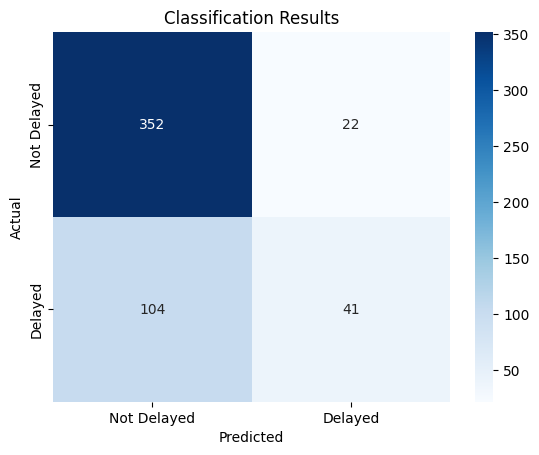

In [29]:
y_pred_class = np.where(y_test_pred < 0.5, 0, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_class), annot=True, fmt="d", cmap="Blues")
plt.title("Classification Results")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["Not Delayed", "Delayed"])
plt.yticks([0.5, 1.5], ["Not Delayed", "Delayed"])

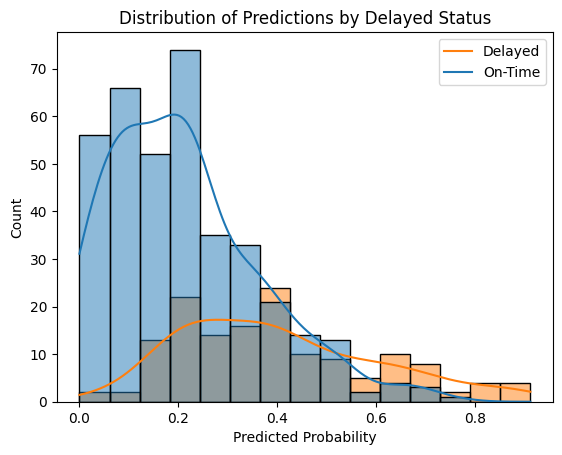

In [30]:

# plot distrubution of predictions by DELAYED
sns.histplot(data=y_test_pred_df, x="proba", bins=15, kde=True, hue="DELAYED")
plt.title("Distribution of Predictions by Delayed Status")
plt.xlabel("Predicted Probability")
plt.legend(["Delayed", "On-Time"])
plt.show()

In [ ]:
# combine train and test data into one dataset
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# Fit model on entire dataset
model.fit(X, y)
with open("models/model.pkl", "wb") as f:
    joblib.dump(model, f)

In [ ]:
new_bookings = pd.read_csv("data/New_bookings.csv", parse_dates=date_cols)
dt = DatasetProcessor()
new_bookings_transformed = dt.transform(new_bookings, carrier_frequencies, labeller)
new_bookings_transformed = transform_hour(new_bookings_transformed, "DELIVERY_HOUR")
new_bookings_transformed = power_transform(new_bookings_transformed, ["SHIPMENT_DURATION", "DELIVERY_WINDOW_DURATION", "DISTANCE"], pt)[column_order]
new_bookings_transformed = scale.transform(new_bookings_transformed)
y_proba = model.predict_proba(new_bookings_transformed)
new_bookings["DELAY_PROBABILITY"] = y_proba[:, 1]

In [ ]:
new_bookings.head()

In [ ]:
new_bookings.to_csv("data/New_bookings_with_predictions.csv", index=False)

In [ ]:
pd.DataFrame.from_records(list(zip(column_order, model.feature_importances_)), columns=["Feature", "Importance"]).sort_values("Importance", ascending=False)